# Transfer Learning in TensorFlow Part 1: Feature extraction

## Import the data

In [8]:
import os
import requests

In [6]:
import zipfile

# URL of the file to download
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

# Local filename
filename = "10_food_classes_10_percent.zip"

# Download the file
response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)

# Unzip the file
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall()
zip_ref.close()

# Remove the zip file
os.remove(filename)

In [9]:
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

> There are only 75 images in the train folders 🧐

## Creating data loaders (preparing the data)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

IMG_SHAPE = (224,224)

# Get all pixel values between 0 & 1
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32, 
                                               target_size=IMG_SHAPE, 
                                               class_mode="categorical")
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=IMG_SHAPE,
                                               class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

<table style="font-size: 17px;">
  <tr>
    <th style="text-align: center;">Callback name</th>
    <th style="text-align: center;">Use case</th> 
    <th style="text-align: center;">Code</th>
  </tr>
  <tr>
    <td style="text-align: center; text-decoration: underline;">TensorBoard</td>
    <td style="text-align: center;">Log the performance of multiple model and then view and compare this models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.</td> 
    <td style="text-align: center;">tf.keras.callbacks.TensorBoard()</td>
  </tr>
  <tr>
    <td style="text-align: center; text-decoration: underline;">Model checkpoint</td>
    <td style="text-align: center;">Save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting</td> 
    <td style="text-align: center;">tf.keras.callbacks.ModelCheckpoint()</td>
  </tr>
  <tr>
    <td style="text-align: center; text-decoration: underline;">Early stopping</td>
    <td style="text-align: center;">Leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take</td> 
    <td style="text-align: center;">tf.keras.callbacks.EarlyStopping()</td>
  </tr>
</table>

In [6]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://www.kaggle.com/models/tensorflow/efficientnet

In [35]:
# Let's compare the following two models
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"

In [8]:
!pip install --upgrade tensorflow_hub

# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) # IMG_SHAPE is (224,224),
                                                                       # the result is (224,224,3)

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [17]:
resnet_model = create_model(model_url=resnet_url,
            num_classes=train_data.num_classes)

In [20]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.legacy.Adam(),
                     metrics=["accuracy"])

In [23]:
resnet_history = resnet_model.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnetV2"
                                                                        )])

Saving TensorBoard log files to: tensorflow_hub/resnetV2/20240104-093524
Epoch 1/5
24/24 [==============================] - 167s 7s/step - loss: 2.2387 - accuracy: 0.3627 - val_loss: 1.1766 - val_accuracy: 0.6104
Epoch 2/5
24/24 [==============================] - 184s 8s/step - loss: 0.9126 - accuracy: 0.6920 - val_loss: 0.8456 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 189s 8s/step - loss: 0.6242 - accuracy: 0.7987 - val_loss: 0.7836 - val_accuracy: 0.7432
Epoch 4/5
24/24 [==============================] - 189s 8s/step - loss: 0.5154 - accuracy: 0.8253 - val_loss: 0.7784 - val_accuracy: 0.7356
Epoch 5/5
24/24 [==============================] - 190s 8s/step - loss: 0.4120 - accuracy: 0.8680 - val_loss: 0.7239 - val_accuracy: 0.7616


**The results are better than the previous model (with only 10% of the data AND a quicker training)!!** 🤯

In [31]:
# Let's plot our loss curves
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  
  Args:
      history: TensorFlow History object.
  Returns:
      Plots of training/validation loss and accuracy metrics
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

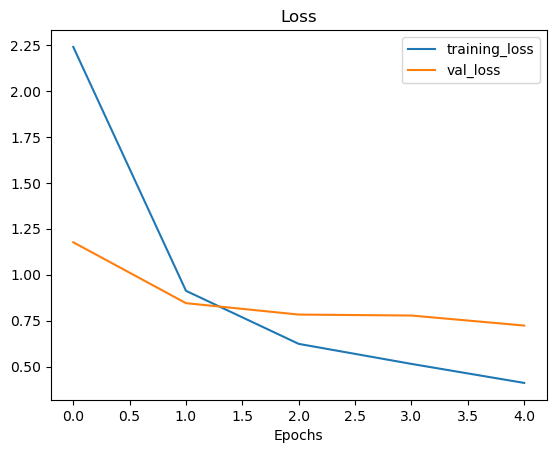

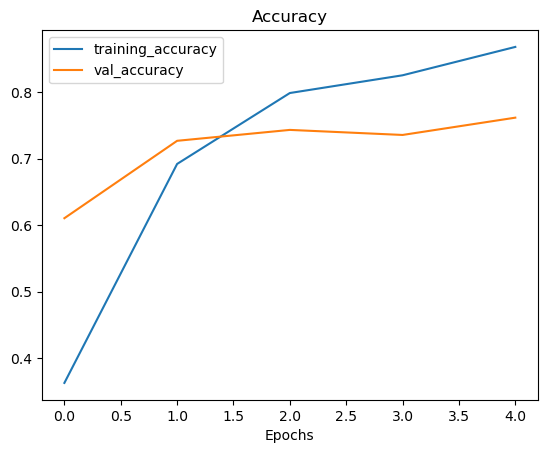

In [32]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [36]:
# Create EfficientNetB0 feature extractor model
efficientNet_model = create_model(model_url=efficientnet_url,
            num_classes=train_data.num_classes)

# Compile model
efficientNet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.legacy.Adam(),
                           metrics=["accuracy"])

# Fit model to 10% of training data
efficientNet_history = efficientNet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240104-112737
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 2.1354 - accuracy: 0.3147 - val_loss: 1.2323 - val_accuracy: 0.5972
Epoch 2/5
24/24 [==============================] - 30s 1s/step - loss: 1.0439 - accuracy: 0.6667 - val_loss: 0.8929 - val_accuracy: 0.7164
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.7868 - accuracy: 0.7467 - val_loss: 0.8208 - val_accuracy: 0.7220
Epoch 4/5
24/24 [==============================] - 33s 1s/step - loss: 0.6499 - accuracy: 0.7987 - val_loss: 0.7700 - val_accuracy: 0.7424
Epoch 5/5
24/24 [==============================] - 34s 1s/step - loss: 0.5431 - accuracy: 0.8493 - val_loss: 0.7296 - val_accuracy: 0.7524


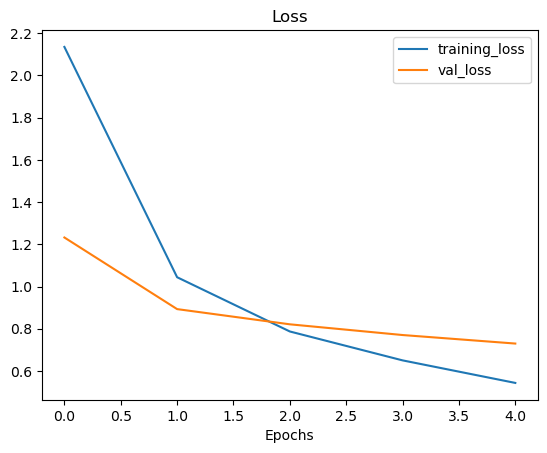

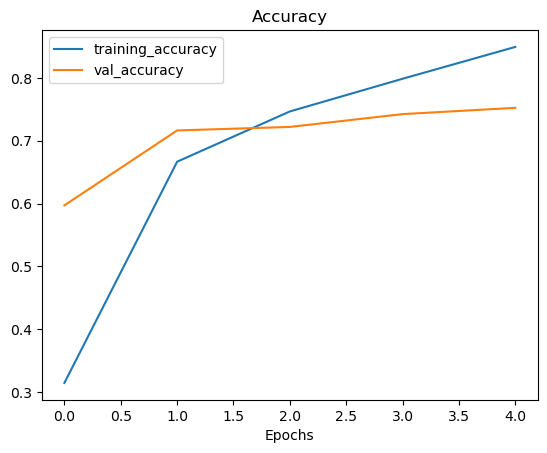

In [37]:
plot_loss_curves(efficientNet_history)

In [38]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              44677609  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 44687629 (170.47 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [39]:
efficientNet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              7200312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 7210322 (27.51 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


In [44]:
# How many layers does efficientnetb0 feature extractor have?
len(resnet_model.layers[0].weights),len(efficientNet_model.layers[0].weights)

(544, 361)

## Diferent types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own).
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food).
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

## Comparing models results using TensorBoard

In [60]:
!tensorboard --logdir ./tensorflow_hub/

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
